In [1]:
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.linalg import eigvals
import random

In [7]:
file_path = '/Users/macbook/Desktop/Research/K-level Network/BeautyContest2018_Dataset.xls'

# Load the Excel file to get the sheet names
xls = pd.ExcelFile(file_path)

# Get the name of the last sheet
last_sheet_name = xls.sheet_names[1]
print(last_sheet_name)

# Read only the fourth column of the last sheet of the Excel file
df = pd.read_excel(file_path, sheet_name=last_sheet_name, usecols=[3])

# Print the DataFrame to see the content
print(df.head())

Lab (Bonn)
   v041_choice
0         25.0
1         20.0
2         25.0
3         35.0
4         60.0


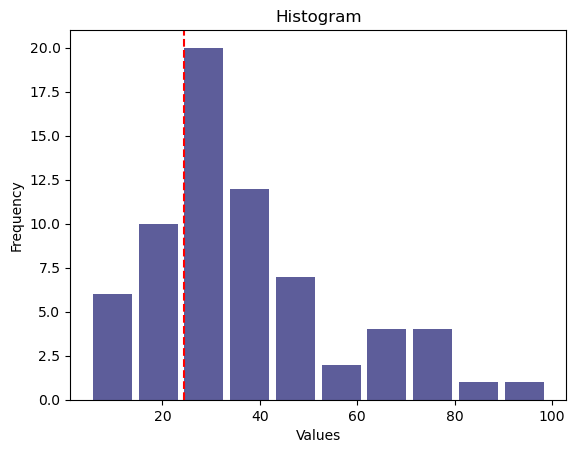

Average Choice: 36.73
Number of Participants: 67


In [55]:
last_sheet_name = xls.sheet_names[1]
df = pd.read_excel(file_path, sheet_name=last_sheet_name, usecols=[3])

# Plotting the histogram
plt.hist(df.iloc[:, 0].dropna(), bins='auto', color='midnightblue', alpha=0.7, rwidth=0.85)  # 'auto' lets matplotlib choose the number of bins
avg_choice = np.mean(df.iloc[:, 0].dropna())
plt.axvline(x=(2/3) * avg_choice, color='red', linestyle='--', label=f'2/3 of Average Choice ({(2/3) * avg_choice:.2f})')
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.title('Histogram')
plt.show()
print(f'Average Choice: {avg_choice:.2f}')
print(f'Number of Participants: {len(df):,}')

# Our Model 

In [56]:
def belief_function(G, node):
    # Getting the outgoing neighbors (for directed graph)
    neighbors = list(G.successors(node))
    if not neighbors:
        # If no outgoing links, belief is a random number between 0 and node's level - 1
        return random.uniform(0, G.nodes[node]['level'] - 1)
    else:
        # The belief is the average level of the outgoing links
        return np.mean([G.nodes[neighbor]['level'] for neighbor in neighbors])


def choice_function(G, node):
    level = G.nodes[node]['level']
    # Randomly choose between a strategic choice and a completely random choice
    avg_belief = belief_function(G, node)
    # Strategic choice based on the average belief
    if level == 0:
        return random.uniform(1, 100)
    else:
        return ((2/3)**(avg_belief + 1)) * 50

def generate_directed_network(level_counts, p):
    G = nx.DiGraph()
    node_count = 0

    # Add nodes with their levels
    for level, count in enumerate(level_counts):
        for _ in range(count):
            G.add_node(node_count, level=level)
            node_count += 1

    # Connect nodes
    if p == 1:
        # In the case of p=1, connect each node in level k to all nodes in levels 0 to k-1
        for node in G.nodes:
            node_level = G.nodes[node]['level']
            for lower_level_node in G.nodes:
                if G.nodes[lower_level_node]['level'] < node_level:
                    G.add_edge(node, lower_level_node)
    elif p == 0:
        # In the case of p=0, return the graph with no edges
        pass
    else:
        # Calculate modified probability for other cases
        kappa = len(level_counts)
        p_hat = (p * (1 - p)) / (1 - p**(kappa - 1))

        # Connect nodes based on calculated probabilities
        for node in G.nodes:
            node_level = G.nodes[node]['level']
            for target_level in range(kappa):
                if node_level > target_level:
                    prob = (p_hat**(node_level - target_level)) * level_counts[target_level]
                    prob /= sum((p_hat**(node_level - k)) * level_counts[k] for k in range(node_level))
                    for target_node in G.nodes:
                        if G.nodes[target_node]['level'] == target_level and random.random() < prob:
                            G.add_edge(node, target_node)

    return G

def plot_choice_frequency(G):
    # Calculate choices for all nodes
    choices = [choice_function(G, node) for node in G.nodes]

    # Plotting the actual number of players choosing each value
    plt.hist(choices, bins=20, color='midnightblue', alpha=0.7, rwidth=0.85)
    plt.xlabel('Choice Value')
    plt.ylabel('Number of Players')
    plt.title('Number of Players Choosing Each Value')
    plt.xlim(0, 100)

    # Marking the 2/3 of the average of all choices with a dashed line
    avg_choice = np.mean(choices)
    plt.axvline(x=(2/3) * avg_choice, color='red', linestyle='--', label=f'2/3 of Average Choice ({(2/3) * avg_choice:.2f})')
    print(f'2/3 of Average Choice: {(2/3) * avg_choice:.2f}')
    plt.legend()

    plt.savefig('k-level synthetic experiments-Game choices.png', dpi=600)
    plt.show()

Total number of nodes: 70
2/3 of Average Choice: 22.07


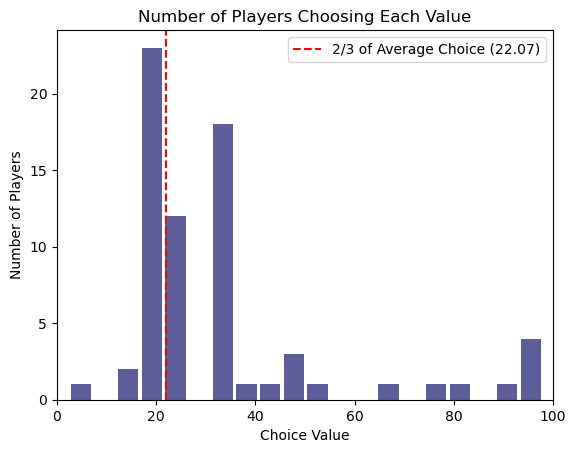

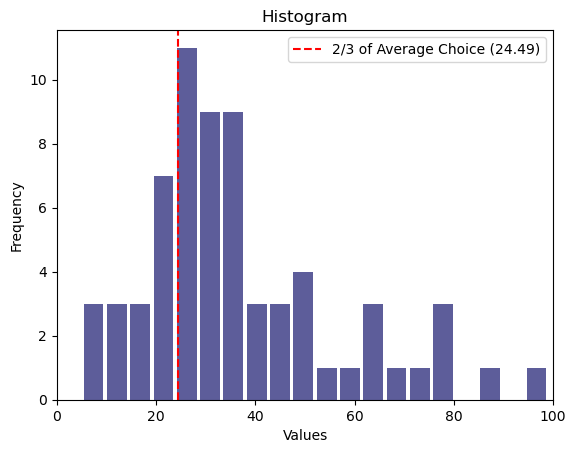

Number of Participants: 67


In [62]:
# Example usage
# total number of players = 3696
# 4 levels --> 7x/2 = 3696 --> x ~ 1056
# Parameters
# Define the mean (λ) of the Poisson distribution
lambda_ = 15  # You can adjust this value as needed
# Define the number of levels
num_levels = 4  # Adjust this to match the number of levels you want
# Generate the level counts using the Poisson distribution
level_counts = np.random.poisson(lambda_, num_levels)
p = 0.5
network = generate_directed_network(level_counts, p)

# total number of nodes 
print(f'Total number of nodes: {network.number_of_nodes():,}')

# Plot the choice frequency for the generated network
plot_choice_frequency(network)

# Plotting the histogram
plt.hist(df.iloc[:, 0].dropna(), bins=20, color='midnightblue', alpha=0.7, rwidth=0.85)  # 'auto' lets matplotlib choose the number of bins
avg_choice = np.mean(df.iloc[:, 0].dropna())
plt.axvline(x=(2/3) * avg_choice, color='red', linestyle='--', label=f'2/3 of Average Choice ({(2/3) * avg_choice:.2f})')
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.xlim(0, 100)
plt.title('Histogram')
plt.legend()
plt.show()
print(f'Number of Participants: {len(df):,}')